In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 19 13:29:30 2022

@author: xdata
"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import math
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
import warnings
import pdb
warnings.filterwarnings('ignore')
import random
from tqdm import tqdm

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)  # 禁止hash随机化


set_seed(42)
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print('训练集的大小为： ', len(train))
print('测试集的大小为： ', len(test))


train = train.dropna()
train.reset_index(drop=True,inplace=True)

label = 'Main_steam_flow_rate'

# =============================================================================
# ['时间', '主蒸汽流量', 'CO含量', 'HCL含量', 'NOx含量', 'SO2含量', '一次风调门', '一次风量',
#        '主蒸汽流量设定值', '二次风调门', '二次风量', '引风机转速', '推料器启停', '推料器手动指令',
#        '推料器自动投退信号', '推料器自动指令', '氧量设定值', '汽包水位', '炉排启停', '炉排实际运行指令',
#        '炉排手动指令', '炉排自动投退信号', '给水流量']
# =============================================================================


训练集的大小为：  257398
测试集的大小为：  1800


In [3]:
train.columns = ['Time', 'Main_steam_flow_rate', 'CO_content', 'HCL_content', 'NOx_content', 'SO2_content', 'Primary_air_regulator', 'Primary_air_volume',
       'Main_steam_flow_rate_setting', 'Secondary_air_regulator', 'Secondary_air_volume', 'Inducer_fan_speed', 'Pusher_start_stop', 'Pusher_manual_command',
       'Pusher_automatic_throwback_signal', 'Pusher_automatic_command', 'Oxygen_setpoint', 'Ladle_water_level', 'Grate_start_stop', 'Grate_actual_operation_command',
       'Grate_manual_command', 'Grate_automatic_throw-out_signal', 'Feedwater_flow']

test.columns = ['Time', 'CO_content', 'HCL_content', 'NOx_content', 'SO2_content', 'Primary_air_regulator', 'Primary_air_volume',
       'Main_steam_flow_rate_setting', 'Secondary_air_regulator', 'Secondary_air_volume', 'Inducer_fan_speed', 'Pusher_start_stop', 'Pusher_manual_command',
       'Pusher_automatic_throwback_signal', 'Pusher_automatic_command', 'Oxygen_setpoint', 'Ladle_water_level', 'Grate_start_stop', 'Grate_actual_operation_command',
       'Grate_manual_command', 'Grate_automatic_throw-out_signal', 'Feedwater_flow']


In [4]:
len(train.columns), len(test.columns)

(23, 22)

In [5]:
data = pd.concat([train, test])
data.index = list(range(len(data)))

In [6]:
# ------------------------------时间特征构造----------------------------------------
# time = pd.to_datetime(data['Time'])
# data['Day'] = time.apply(lambda x: x.day)
# data['Hour'] = time.apply(lambda x: x.hour)
# data['Minute'] = time.apply(lambda x: x.minute)
# # --------------------------------end--------------------------------------------
#

In [7]:
# data['Minute']


In [8]:
data['gas'] = data.CO_content + data.HCL_content + data.SO2_content + data.NOx_content

# features_names = ['CO_content', 'HCL_content', 'NOx_content', 'SO2_content', 'Primary_air_regulator', 'Primary_air_volume',
#        'Main_steam_flow_rate_setting', 'Secondary_air_regulator', 'Secondary_air_volume', 'Inducer_fan_speed', 'Pusher_manual_command',
#        'Pusher_automatic_command', 'Oxygen_setpoint', 'Ladle_water_level', 'Grate_actual_operation_command',
#        'Grate_manual_command', 'Feedwater_flow']
features_names = ['Feedwater_flow', 'Oxygen_setpoint', 'Primary_air_volume', 'Main_steam_flow_rate_setting', 'Ladle_water_level']
for f in tqdm(features_names):

    # 滑动窗口特征
    window_list = [300, 600, 900]
    for win_size in window_list:
        data[f+'_fore_steps_mean_'+str(win_size)] = data[f].rolling(window=win_size, center=False).mean()
        data[f+'_fore_steps_max_'+str(win_size)] = data[f].rolling(window=win_size, center=False).max()
        data[f+'_fore_steps_min_'+str(win_size)] = data[f].rolling(window=win_size, center=False).min()
        data[f+'_fore_steps_std_'+str(win_size)] = data[f].rolling(window=win_size, center=False).std()
        data[f+'_fore_steps_skew_'+str(win_size)] = data[f].rolling(window=win_size, center=False).skew()

    # n阶差分特征
    diff_list = list(range(1, 60))
    for diff_size in diff_list:
        data[f+'_diff_'+str(diff_size)] = data[f].diff(periods=diff_size)

100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


In [9]:
f = 'Main_steam_flow_rate'
# 滑动窗口特征
window_list = [1800]
for win_size in tqdm(window_list):
    # 因为是标签，当前时刻是没预测的，所以得除去当前时刻的再计算。
    # data[f+'_fore_steps_mean_'+str(win_size)] = (data[f].rolling(window=win_size, center=False).sum()-data[f]) / (win_size-1)


    mean_list = []
    for ser in data[f].rolling(window=win_size, center=False):
        mean_list.append(ser[:-1].mean())
    data[f+'_fore_steps_mean_'+str(win_size)] = mean_list


    max_list = []
    for ser in data[f].rolling(window=win_size, center=False):
        max_list.append(ser[:-1].max())
    data[f+'_fore_steps_max_'+str(win_size)] = max_list

    min_list = []
    for ser in data[f].rolling(window=win_size, center=False):
        min_list.append(ser[:-1].min())
    data[f+'_fore_steps_min_'+str(win_size)] = min_list

    std_list = []
    for ser in data[f].rolling(window=win_size, center=False):
        std_list.append(ser[:-1].std())
    data[f+'_fore_steps_std_'+str(win_size)] = std_list

    skew_list = []
    for ser in data[f].rolling(window=win_size, center=False):
        skew_list.append(ser[:-1].skew())
    data[f+'_fore_steps_skew_'+str(win_size)] = skew_list
    # data[f+'_fore_steps_max_'+str(win_size)] = data[f].rolling(window=win_size, center=False).max()
    # data[f+'_fore_steps_min_'+str(win_size)] = data[f].rolling(window=win_size, center=False).min()
    # data[f+'_fore_steps_std_'+str(win_size)] = data[f].rolling(window=win_size, center=False).std()
    # data[f+'_fore_steps_skew_'+str(win_size)] = data[f].rolling(window=win_size, center=False).skew()

# n阶差分特征
# diff_list = list(range(1, 60))
# for diff_size in diff_list:
#     data[f+'_diff_'+str(diff_size)] = data[f].diff(periods=diff_size)

100%|██████████| 1/1 [01:50<00:00, 110.19s/it]


In [10]:
# f = 'Main_steam_flow_rate'
# data[f+'_fore_steps_min_'+str(300)][-1800:]

In [11]:
# len(shift_f[:10])

In [12]:
data['Grate_start_stop'] = data['Grate_start_stop'].map(int)
data['Pusher_start_stop'] = data['Pusher_start_stop'].map(int)
data['Pusher_automatic_throwback_signal'] = data['Pusher_automatic_throwback_signal'].map(int)
data['Grate_automatic_throw-out_signal'] = data['Grate_automatic_throw-out_signal'].map(int)

In [13]:
# 3、内存压缩
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in tqdm(df.columns):
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (
                start_mem - end_mem) / start_mem))
    return df


# 压缩使用内存
# 由于数据比较大，所以合理的压缩内存节省空间尤为的重要
# 使用reduce_mem_usage函数可以压缩近70%的内存占有。
data = reduce_mem_usage(data)

100%|██████████| 399/399 [00:01<00:00, 270.22it/s]


Mem. usage decreased to 204.66 Mb (74.1% reduction)


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259182 entries, 0 to 259181
Columns: 399 entries, Time to Main_steam_flow_rate_fore_steps_skew_1800
dtypes: float16(384), float32(10), int8(4), object(1)
memory usage: 204.7+ MB


In [15]:
test = data.tail(1800)
train = data.iloc[:-1800, :]
train.reset_index(drop=True,inplace=True)

valid = train.iloc[-1800:, :]
train = train.iloc[:-1800, :]

valid.reset_index(drop=True, inplace=True)



features = train.columns.drop(['Time',label]).tolist()

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'l2_root',
    'learning_rate': 0.01,
    'reg_alpha': 0.7,
    'reg_lambda': 35,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'feature_fraction': 0.7,
    "random_seed": 1,
}

dtrain = lgb.Dataset(train[features],label=train[label])
dvalid = lgb.Dataset(valid[features],label=valid[label])

watchlist = [dtrain,dvalid]
model = lgb.train(params,train_set=dtrain,num_boost_round=10000,early_stopping_rounds=1000,valid_sets=watchlist,verbose_eval=200)

feature_importance = pd.DataFrame()
feature_importance['fea_name'] = features
feature_importance['fea_imp'] = model.feature_importance()
feature_importance = feature_importance.sort_values('fea_imp',ascending = False)




sub = test[['Time']]
sub['lgb'+label] = model.predict(test[features])
sub.reset_index(inplace=True)
sub.columns=['ID','Time','Steam_flow']

# sub.to_csv('result.csv',index=False)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.346349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99325
[LightGBM] [Info] Number of data points in the train set: 255582, number of used features: 397
[LightGBM] [Info] Start training from score 58.093750
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 2.18503	valid_1's rmse: 2.31997
[400]	training's rmse: 1.35609	valid_1's rmse: 1.86251
[600]	training's rmse: 1.02435	valid_1's rmse: 1.65603
[800]	training's rmse: 0.80199	valid_1's rmse: 1.53832
[1000]	training's rmse: 0.674694	valid_1's rmse: 1.49303
[1200]	training's rmse: 0.588295	valid_1's rmse: 1.47394
[1400]	training's rmse: 0.532298	valid_1's rmse: 1.45718
[1600]	training's rmse: 0.493642	valid_1's rmse: 1.44334
[1800]	training's rmse: 0.459809	valid_1's rmse: 1.42922
[2000]	training's rmse: 0.432892	valid_1's rmse: 1.41901
[2200]	training's rmse: 0.

In [16]:
feature_importance

,fea_name,fea_imp
20,Feedwater_flow,5347
323,Ladle_water_level_fore_steps_mean_600,3675
393,Main_steam_flow_rate_fore_steps_max_1800,2863
15,Ladle_water_level,2608
318,Ladle_water_level_fore_steps_mean_300,2562
...,...,...
144,Oxygen_setpoint_diff_34,0
186,Primary_air_volume_diff_2,0
185,Primary_air_volume_diff_1,0
149,Oxygen_setpoint_diff_39,0


In [17]:
# features

In [18]:
all_df = pd.concat([train, valid, test])
all_df.index = list(range(len(all_df)))

In [19]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259182 entries, 0 to 259181
Columns: 399 entries, Time to Main_steam_flow_rate_fore_steps_skew_1800
dtypes: float16(384), float32(10), int8(4), object(1)
memory usage: 204.7+ MB


In [22]:
f = 'Main_steam_flow_rate'
pred_list = []
for i in tqdm(test.index):
    window_list = [1800]
    for win_size in window_list:
        all_df[f+'_fore_steps_mean_'+str(win_size)][i] = (all_df[f][i-win_size:i]).mean()
        # print('-'*10)
        # print(test[f+'_fore_steps_mean_'+str(win_size)][i])
        # print('-'*10)
        all_df[f+'_fore_steps_max_'+str(win_size)][i] = (all_df[f][i-win_size:i]).max()
        all_df[f+'_fore_steps_min_'+str(win_size)][i] = (all_df[f][i-win_size:i]).min()
        all_df[f+'_fore_steps_std_'+str(win_size)][i] = (all_df[f][i-win_size:i]).std()
        all_df[f+'_fore_steps_skew_'+str(win_size)][i] = (all_df[f][i-win_size:i]).skew()
    x = all_df[features].loc[i]
    y = model.predict(x)[0]
    all_df[f][i] = y
    pred_list.append(y)

100%|██████████| 1800/1800 [04:41<00:00,  6.40it/s]


In [ ]:
# all_df[f+'_fore_steps_mean_'+str(300)][-1800:]

In [ ]:
# i = test.index[0]
# all_df[f][test.index[0]-300, test.index[0]]

In [ ]:
i = test.index[0]
all_df[f+'_fore_steps_mean_'+str(300)][i]

In [ ]:
all_df[f][i-300:i]

In [ ]:
np.mean(pred_list)

In [ ]:
pd.Series(pred_list).describe()

In [ ]:
# pred_list = [i[0] for i in pred_list]

In [23]:
sub['Steam_flow'] = pred_list
sub['ID'] = list(range(1800))
sub.to_csv('result.csv',index=False)

In [24]:
max(pred_list)

63.34949113317607

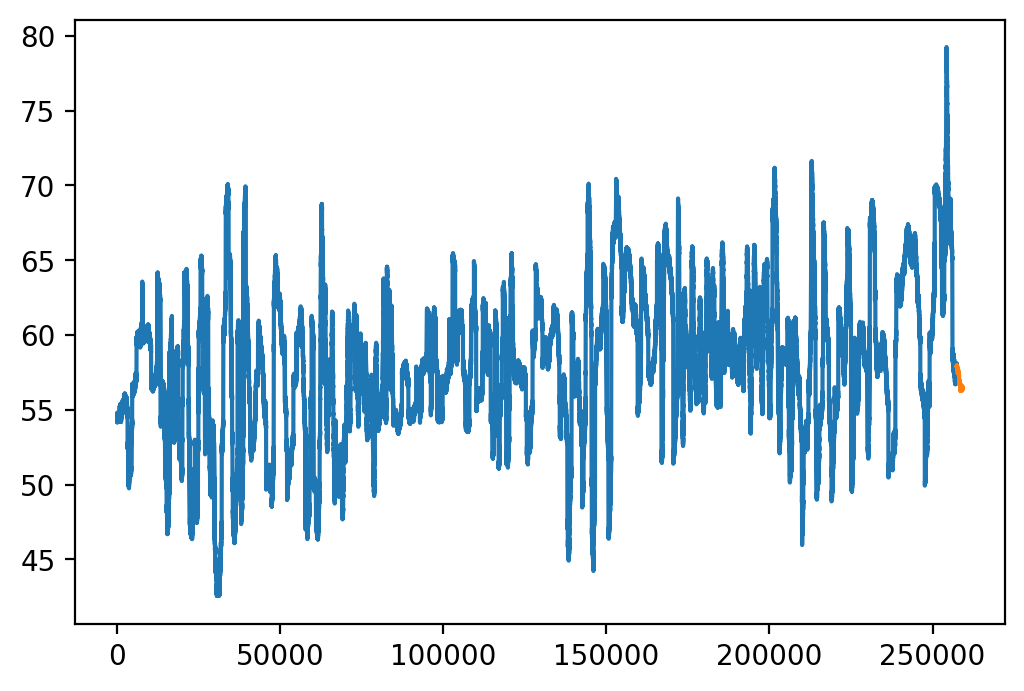

In [32]:
import matplotlib.pyplot as plt
train = pd.read_csv('data/train.csv')
t1 = train['主蒸汽流量'].tolist()
t2 = sub['Steam_flow'].tolist()
plt.figure(dpi=200)
plt.plot(list(range(len(t1))), t1)
plt.plot(list(range(len(t1), len(t1)+len(t2))), t2)
plt.savefig('./pred.jpg')



In [306]:
len(t2)

1800

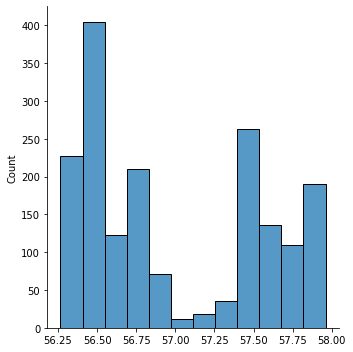

In [33]:
import seaborn as sbs
sbs.displot(pred_list)

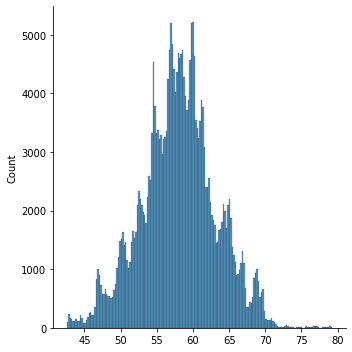

In [34]:
sbs.displot(t1)


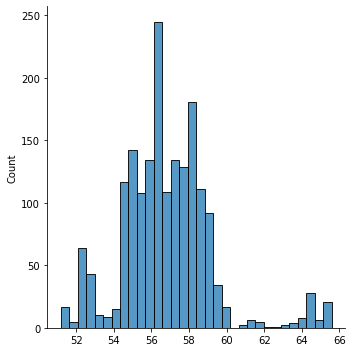

In [313]:
demo = pd.read_csv('./demo2.csv')
t3 = demo['Steam_flow'].tolist()
sbs.displot(t3)

In [35]:
valid

,Time,Main_steam_flow_rate,CO_content,HCL_content,NOx_content,SO2_content,Primary_air_regulator,Primary_air_volume,Main_steam_flow_rate_setting,Secondary_air_regulator,...,Main_steam_flow_rate_fore_steps_mean_600,Main_steam_flow_rate_fore_steps_max_600,Main_steam_flow_rate_fore_steps_min_600,Main_steam_flow_rate_fore_steps_std_600,Main_steam_flow_rate_fore_steps_skew_600,Main_steam_flow_rate_fore_steps_mean_900,Main_steam_flow_rate_fore_steps_max_900,Main_steam_flow_rate_fore_steps_min_900,Main_steam_flow_rate_fore_steps_std_900,Main_steam_flow_rate_fore_steps_skew_900
0,2021-12-22 23:00:00,68.25000,300.000000,2.222656,31.671875,194.375000,30.343750,32417.697266,60.0,89.43750,...,67.75000,69.1875,66.0625,0.951660,-0.223999,68.4375,71.62500,66.0625,1.343750,0.240967
1,2021-12-22 23:00:01,68.25000,300.000000,2.222656,31.671875,194.375000,30.343750,32417.697266,60.0,89.43750,...,67.75000,69.1875,66.0625,0.950684,-0.224121,68.4375,71.62500,66.0625,1.339844,0.237671
2,2021-12-22 23:00:02,68.31250,300.250000,2.216797,31.484375,194.250000,30.312500,32192.269531,60.0,89.43750,...,67.75000,69.1875,66.0625,0.949707,-0.223877,68.4375,71.50000,66.0625,1.335938,0.233032
3,2021-12-22 23:00:03,68.25000,300.000000,2.250000,31.500000,194.250000,30.328125,32122.589844,60.0,89.43750,...,67.75000,69.1875,66.0625,0.948730,-0.224487,68.4375,71.50000,66.0625,1.332031,0.230225
4,2021-12-22 23:00:04,68.18750,300.250000,2.267578,31.593750,194.125000,30.343750,32296.507812,60.0,89.50000,...,67.75000,69.1875,66.0625,0.947266,-0.225342,68.4375,71.50000,66.0625,1.328125,0.227051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,2021-12-22 23:29:55,57.78125,2.304688,2.648438,111.625000,2.791016,65.562500,72750.445312,60.0,49.53125,...,57.31250,58.1250,56.6875,0.323486,0.122375,57.5625,58.71875,56.6875,0.458984,0.187500
1796,2021-12-22 23:29:56,57.81250,2.541016,2.773438,111.562500,3.257812,65.562500,72642.570312,60.0,49.50000,...,57.31250,58.1250,56.6875,0.324219,0.120667,57.5625,58.71875,56.6875,0.458252,0.186768
1797,2021-12-22 23:29:57,57.78125,2.521484,2.804688,111.687500,3.250000,65.562500,72248.210938,60.0,49.46875,...,57.31250,58.1250,56.6875,0.324707,0.119568,57.5625,58.71875,56.6875,0.457520,0.186035
1798,2021-12-22 23:29:58,57.75000,2.478516,2.814453,111.562500,3.320312,65.562500,72480.445312,60.0,49.46875,...,57.34375,58.1250,56.6875,0.325195,0.116699,57.5625,58.71875,56.6875,0.456787,0.185425
